# This notebook is to compare caffe and nvdla with 42 images.

## TODO: 

### Implement funtions:

* catch all filenames 
* classify filenames by image name (total 41 images)
* according image name to analyze every layer difference between caffe and nvdla (total 12 layers)

### Envirnment 
* nvdla/sw @ **2018/6/30**
* nvdla/hw @ **nvdlav1**
* model: BVLC/caffe example cifar10 quick, **iter. 4000**
* Input images were not any processed on NVDLA and Caffe, so accurarcy is **very bad**. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy
import csv
import itertools
from natsort import natsorted

## Configure max read file size

In [2]:
# Set the csv limitation 
maxInt = sys.maxsize
decrement = True

while decrement:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    decrement = False
    try:
        csv.field_size_limit(maxInt)
    except OverflowError:
        maxInt = int(maxInt/10)
        decrement = True

# Function Defination
## Read files

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [4]:
def getfrombigtxt(fname, delimiter=' '):
    tmp = []
    with open(fname, 'r') as f: # note text mode, not binary
        for row in csv.reader(f):
            for elements in row[0].split(delimiter):
#                 tmp.append(map(float, elements))
                tmp.append((elements))
    del tmp[-1]
    return np.asarray(tmp,dtype=np.float32)

In [5]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

## Loss funtions

In [6]:
def accu_diff(nvdla, caffe):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(nvdla,caffe)))

In [7]:
def accu_diff_mean(nvdla, caffe):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(nvdla,caffe)))/len(caffe)

In [8]:
# use |nvdla-caffe| divide to three times variance / standard deviation to measure caffe and nvdla difference size
def accu_diff_mean_std(nvdla, caffe):
    return (np.sum(accu_diff_mean(nvdla, caffe))/(6*np.std(caffe, ddof = 1)))

In [9]:
# WARNNINGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG this is a method. 
# use error rate mean to measure caffe and nvdla difference
# error rate = Mean(NVDLA output tensor / Caffe output tensor)
def error_rate_mean(nvdla, caffe):
    return np.mean(nvdla/(caffe+1e-10))

In [10]:
bb = np.asarray([1,2,3])
aa = np.asarray([2,4,6])
error_rate_mean(aa,bb)

1.9999999998777778

In [11]:
def rms(arr1, arr2):
#     print arr1, arr2
    return np.sqrt(np.sum(np.power(np.subtract(arr1,arr2),2)))

In [12]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

## Display funtions

In [13]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0, filename= 'test'):
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    # save image 
#     plt.savefig(filename +".png") 
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Caffe inference

In [14]:
def caffe_inference(image_path, model_def = 'prototxt/yolo_tiny_deploy_10.prototxt'  , weight = 'weight/yolo_tiny.caffemodel'):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/yolo'
    input_file = image_path
    model_def = os.path.join(model_dir,model_def)
    pretrained_model = os.path.join(model_dir, weight)
    gpu = False
    center_only = True
    images_dim = '32,32'
    mean_file = None
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)
    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

# Entry Point
## Read files

In [15]:
dimg_root = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/dimg_cifar_quick_42_image_each_layer'
image_root = '/home/caslab/workspace/dataset/cifar/mix/'
prototxt_root = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/prototxt/'

In [16]:
# Get image file name set
image_file_names = []
for root, directories, filenames in os.walk(image_root):
    for filename in filenames:
        image_file_names.append(filename.split(".")[0])

# Get layer name (total)
prototxt_file_names = []
for root, directories, filenames in os.walk(prototxt_root):
    for filename in filenames:
        prototxt_file_names.append(filename.split(".")[0])
prototxt_file_names.sort()

In [17]:
result_list = []
weight_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/model/cifar_quick/weight/cifar10_quick_iter_4000.caffemodel'
for image_file in image_file_names:
    for prototxt_file in prototxt_file_names:
        dimg_file_name = image_file + "_" + prototxt_file + ".dimg"
        
#         print dimg_file_name
        
        dimg_path = os.path.join(dimg_root,dimg_file_name)
        image_file_name = image_file + ".jpg"
        image_path = os.path.join(image_root,image_file_name)
        prototxt_file_name = prototxt_file + ".prototxt"
        prototxt_path = os.path.join(prototxt_root,prototxt_file_name)
        nvdla_tmp = getfrombigtxt(dimg_path)
        caffe_tmp = caffe_inference(image_path,prototxt_path,weight_path)
        diff_tmp = accu_diff_mean(nvdla_tmp,caffe_tmp.flatten())
        result_dist = {"image_name":image_file
              ,"layer":prototxt_file.split("_")[-1]
              ,"nvdla":nvdla_tmp
              ,"caffe":caffe_tmp
              ,"diff":diff_tmp}
        result_list.append(result_dist)

In [18]:
tmp = 'none'
i = 0
for result in result_list:
    if tmp != result['image_name']:
        print "==============================="
    tmp = result['image_name']
    print ("[%d]image: %s \t layer: %s\t diff: %.3f"%(i,result['image_name'],result['layer'],result['diff']))
    i+=1

[0]image: 16_dog 	 layer: conv1	 diff: 0.009
[1]image: 16_dog 	 layer: pool1	 diff: 0.009
[2]image: 16_dog 	 layer: relu1	 diff: 0.007
[3]image: 16_dog 	 layer: conv2	 diff: 0.012
[4]image: 16_dog 	 layer: pool2	 diff: 0.001
[5]image: 16_dog 	 layer: relu2	 diff: 0.374
[6]image: 16_dog 	 layer: conv3	 diff: 0.481
[7]image: 16_dog 	 layer: pool3	 diff: 0.097
[8]image: 16_dog 	 layer: relu3	 diff: 0.138
[9]image: 16_dog 	 layer: ip1	 diff: 1.064
[10]image: 16_dog 	 layer: ip2	 diff: 0.963
[11]image: 16_dog 	 layer: prob	 diff: 0.001
[12]image: 59_cat 	 layer: conv1	 diff: 0.007
[13]image: 59_cat 	 layer: pool1	 diff: 0.007
[14]image: 59_cat 	 layer: relu1	 diff: 0.006
[15]image: 59_cat 	 layer: conv2	 diff: 0.010
[16]image: 59_cat 	 layer: pool2	 diff: 0.001
[17]image: 59_cat 	 layer: relu2	 diff: 0.289
[18]image: 59_cat 	 layer: conv3	 diff: 0.439
[19]image: 59_cat 	 layer: pool3	 diff: 0.116
[20]image: 59_cat 	 layer: relu3	 diff: 0.179
[21]image: 59_cat 	 layer: ip1	 diff: 0.962
[22]i

image: 16_dog 	 layer: prob	 diff: 0.001



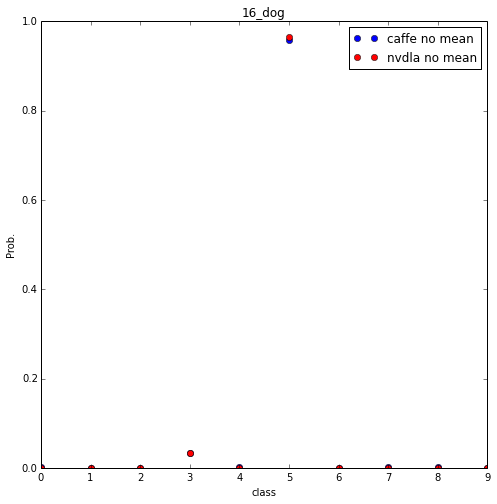

image: 59_cat 	 layer: prob	 diff: 0.047



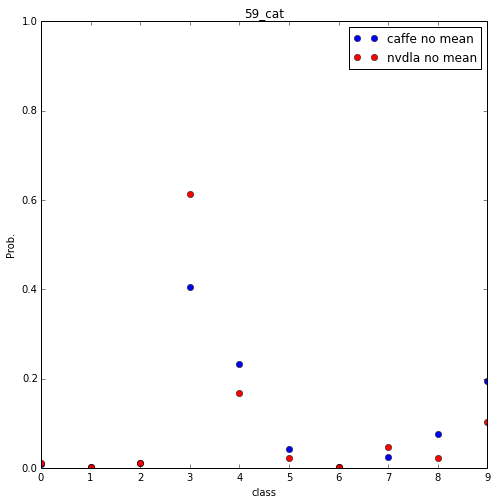

image: 9_automobile 	 layer: prob	 diff: 0.045



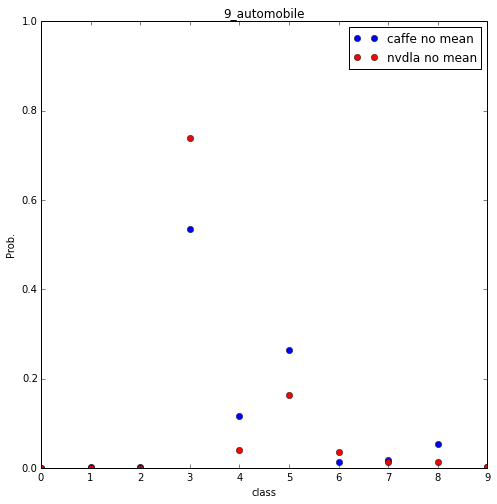

image: 13_horse 	 layer: prob	 diff: 0.008



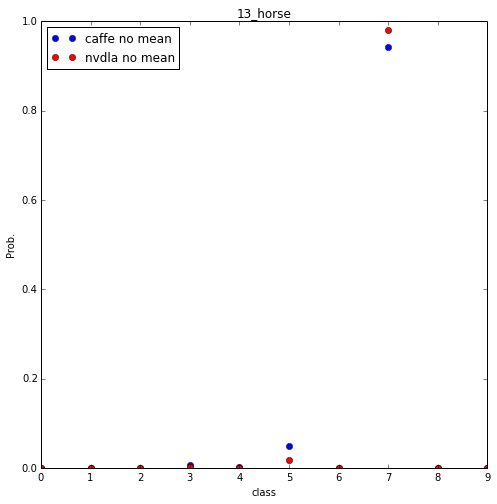

image: 53_truck 	 layer: prob	 diff: 0.035



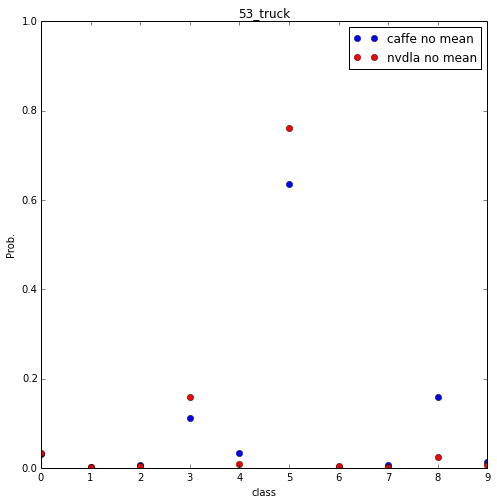

image: 114_horse 	 layer: prob	 diff: 0.069



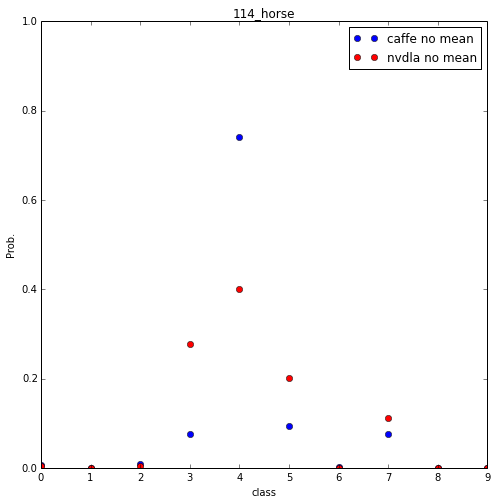

image: 67_truck 	 layer: prob	 diff: 0.054



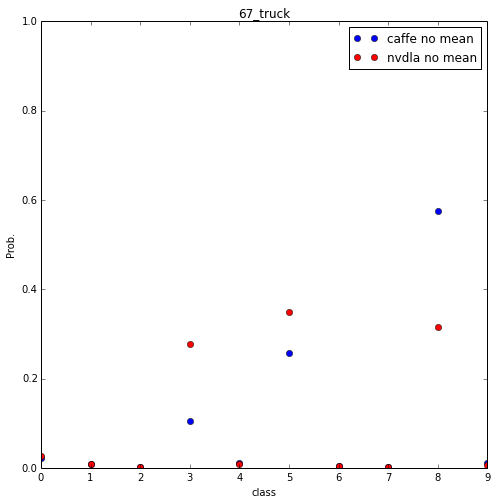

image: 18_ship 	 layer: prob	 diff: 0.000



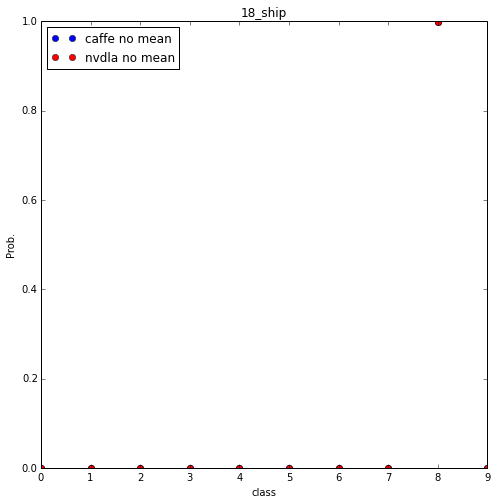

image: 107_dog 	 layer: prob	 diff: 0.020



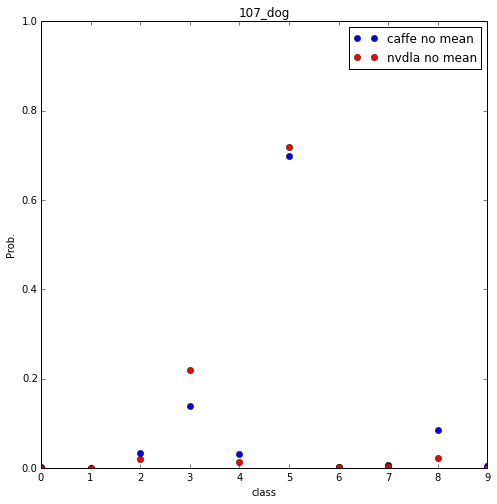

image: 68_horse 	 layer: prob	 diff: 0.024



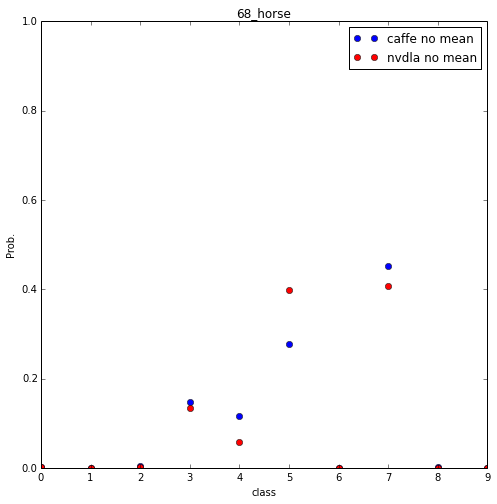

image: 21_cat 	 layer: prob	 diff: 0.044



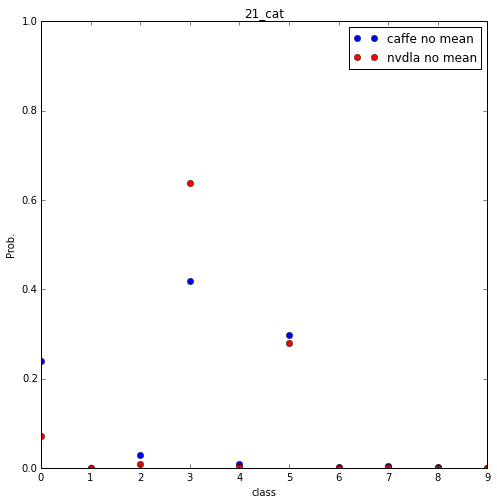

image: 63_bird 	 layer: prob	 diff: 0.038



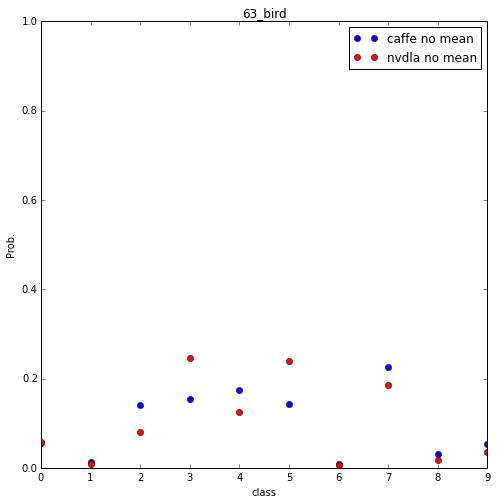

image: 110_truck 	 layer: prob	 diff: 0.015



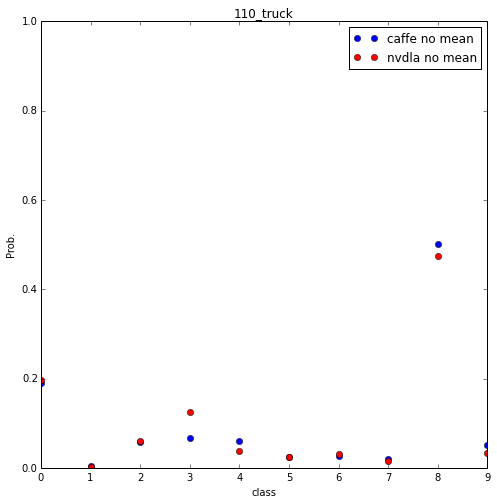

image: 85_horse 	 layer: prob	 diff: 0.011



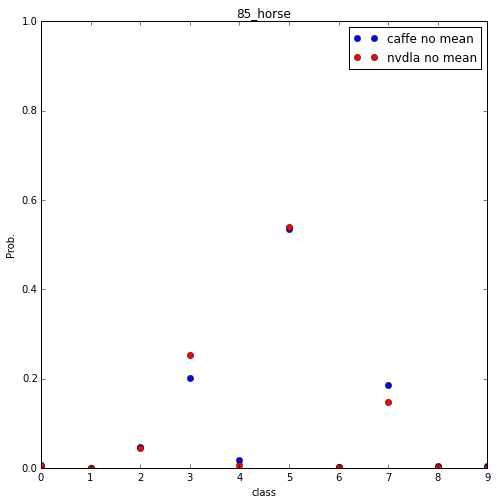

image: 105_automobile 	 layer: prob	 diff: 0.021



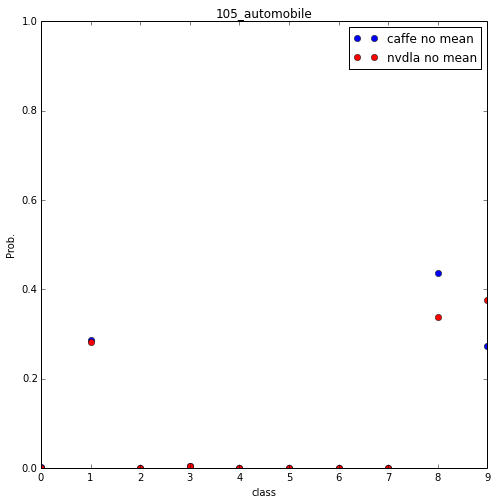

image: 115_airplane 	 layer: prob	 diff: 0.063



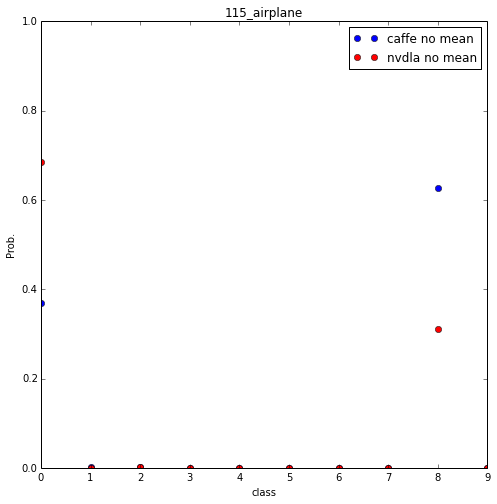

image: 21_airplane 	 layer: prob	 diff: 0.004



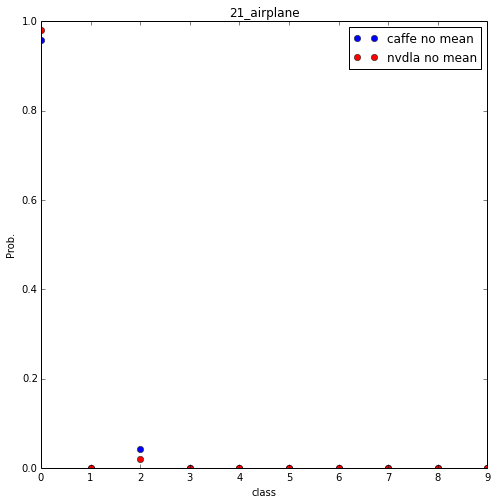

image: 103_frog 	 layer: prob	 diff: 0.011



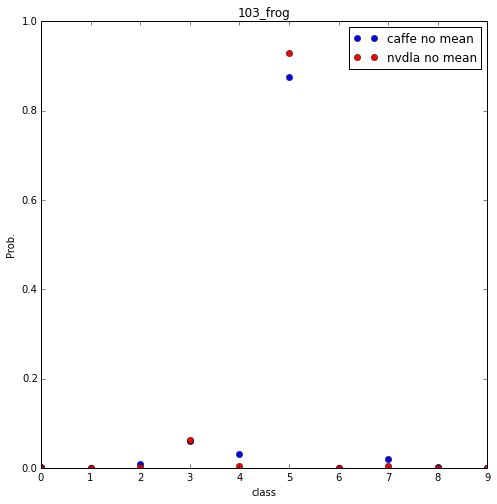

image: 112_automobile 	 layer: prob	 diff: 0.037



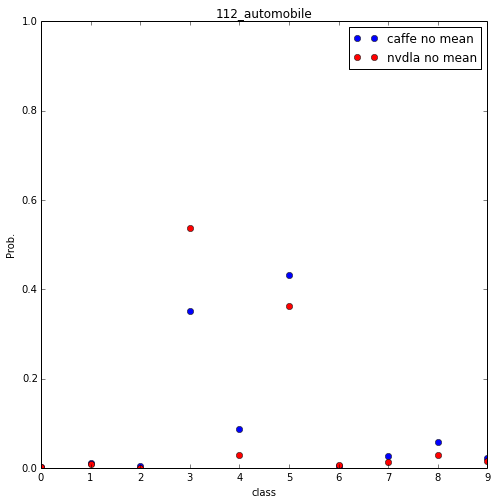

image: 5_automobile 	 layer: prob	 diff: 0.056



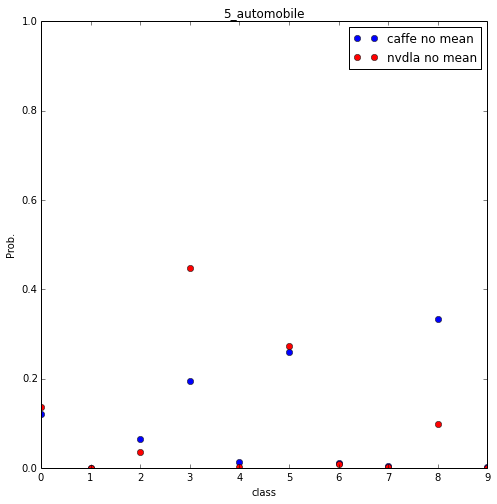

image: 1_ship 	 layer: prob	 diff: 0.001



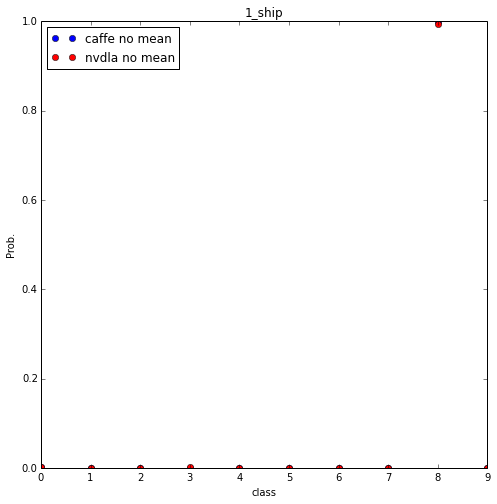

image: 98_deer 	 layer: prob	 diff: 0.025



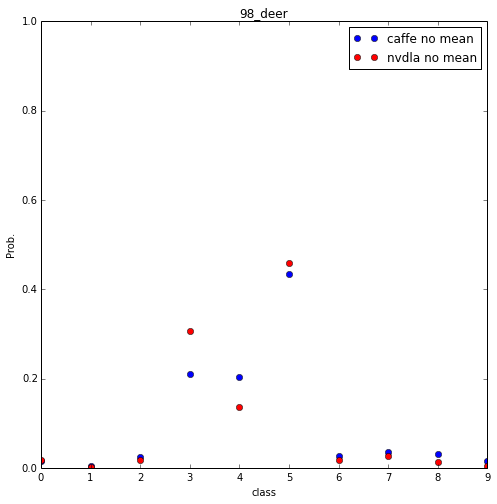

image: 104_frog 	 layer: prob	 diff: 0.048



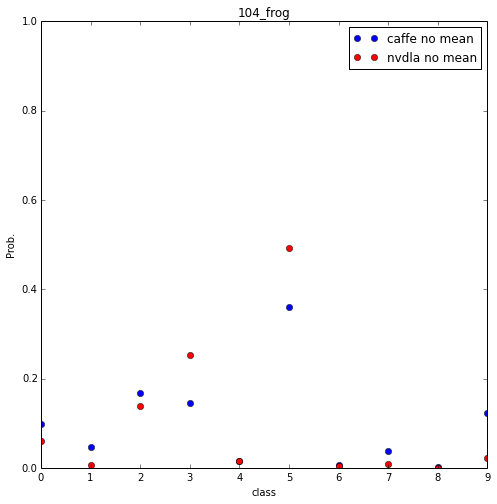

image: 61_automobile 	 layer: prob	 diff: 0.054



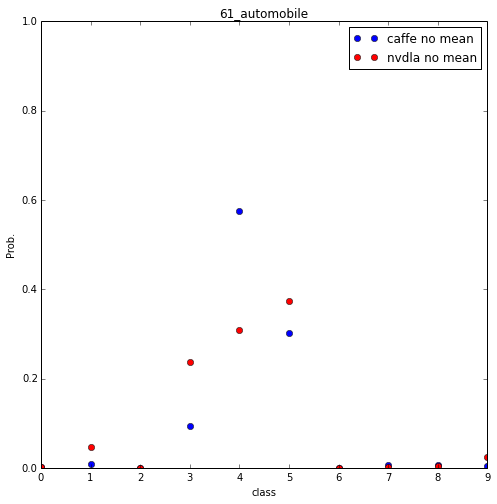

image: 34_deer 	 layer: prob	 diff: 0.026



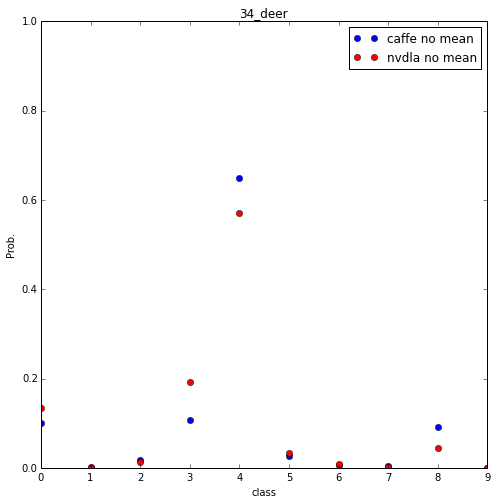

image: 87_horse 	 layer: prob	 diff: 0.018



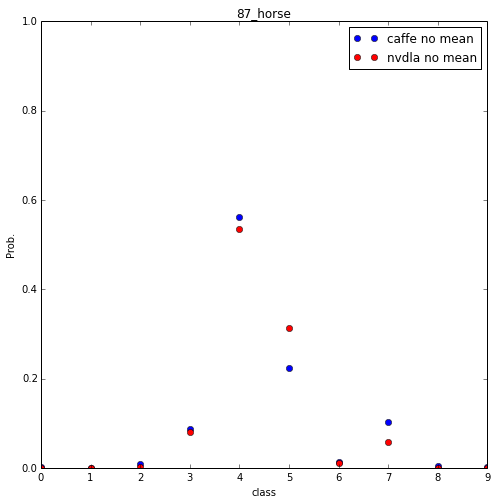

image: 43_horse 	 layer: prob	 diff: 0.033



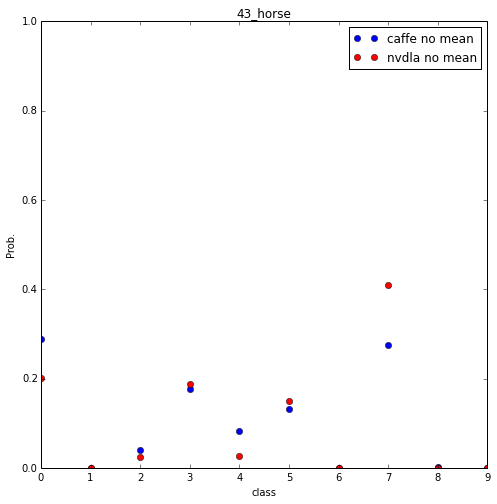

image: 92_ship 	 layer: prob	 diff: 0.045



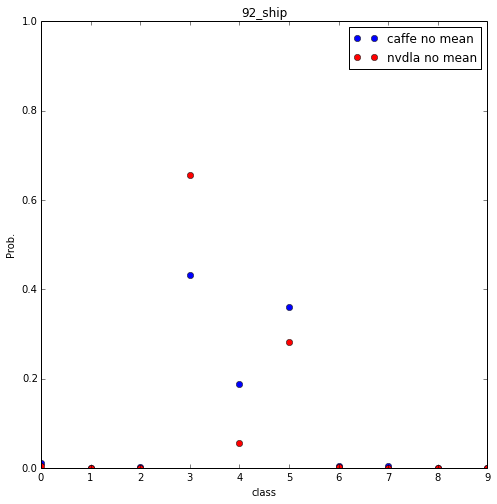

image: 118_truck 	 layer: prob	 diff: 0.080



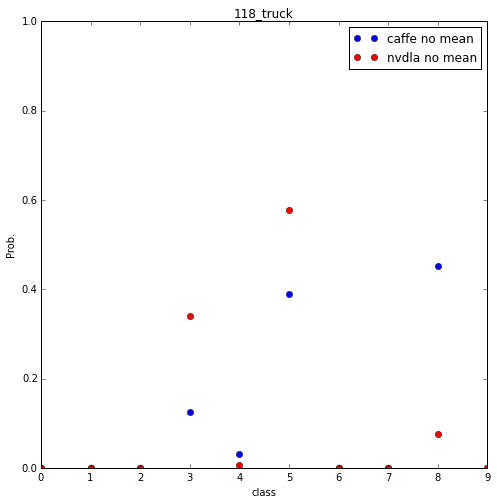

image: 4_automobile 	 layer: prob	 diff: 0.039



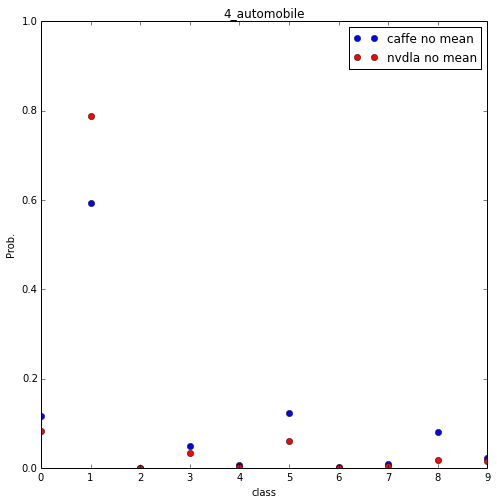

image: 16_truck 	 layer: prob	 diff: 0.022



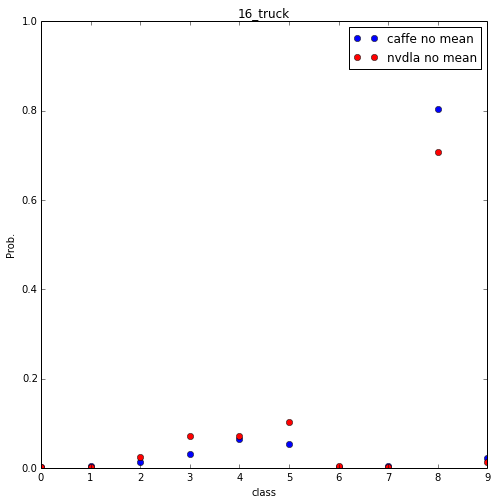

image: 8_ship 	 layer: prob	 diff: 0.038



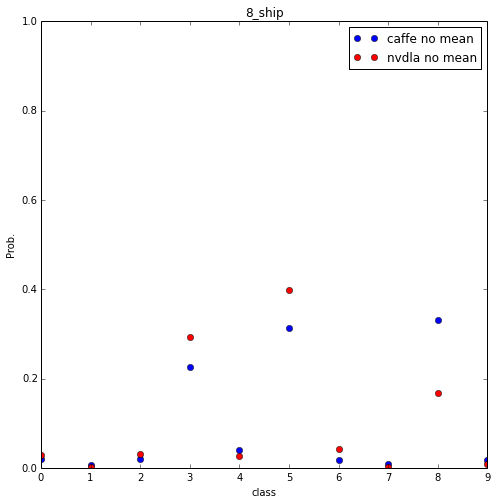

image: 8_cat 	 layer: prob	 diff: 0.008



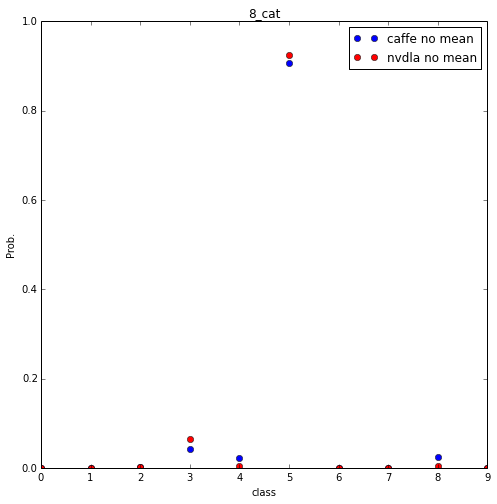

image: 128_dog 	 layer: prob	 diff: 0.051



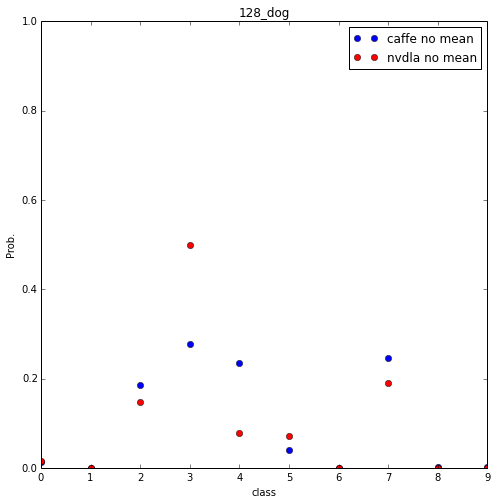

image: 12_dog 	 layer: prob	 diff: 0.019



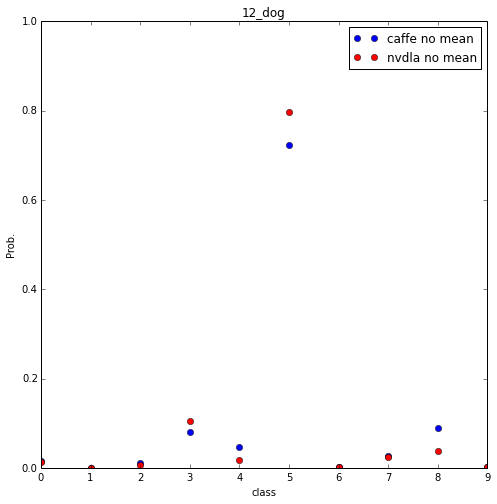

image: 11_horse 	 layer: prob	 diff: 0.059



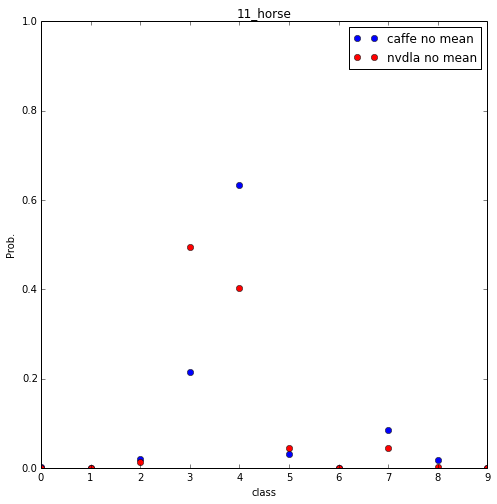

image: 0_cat 	 layer: prob	 diff: 0.017



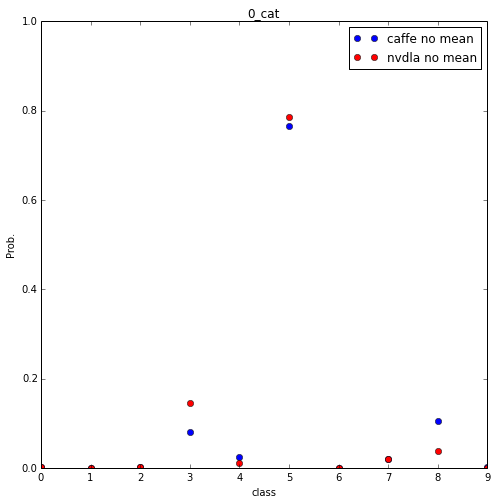

image: 14_truck 	 layer: prob	 diff: 0.005



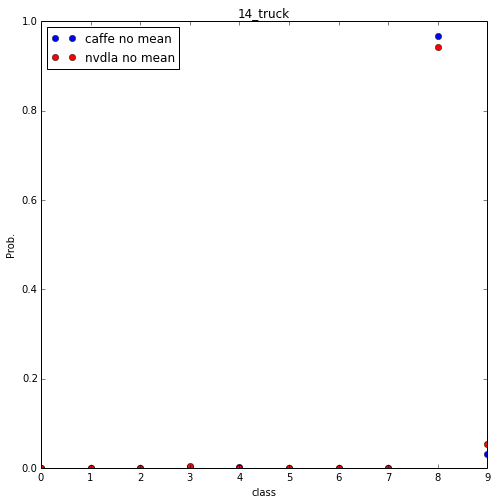

image: 27_dog 	 layer: prob	 diff: 0.040



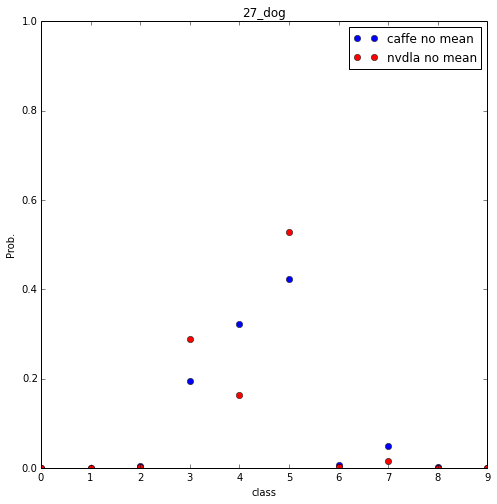

image: 10_airplane 	 layer: prob	 diff: 0.036



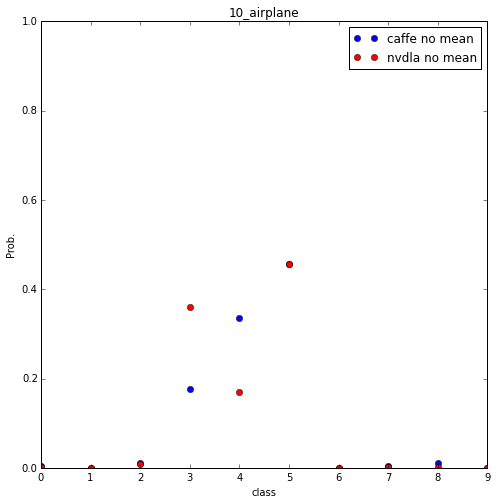

image: 20_horse 	 layer: prob	 diff: 0.046



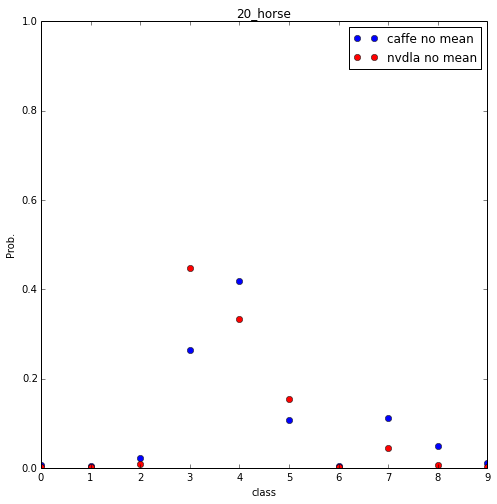

image: 11_truck 	 layer: prob	 diff: 0.036



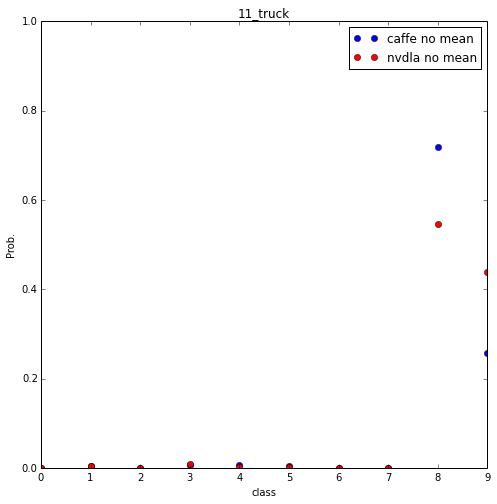

In [19]:
# pixel_width = 6
# pixel_height = 6
# plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,10)
for result in result_list:
    if result['layer'] == "prob":
        l1, = plt.plot(aa,result['nvdla'], 'bo' , label = 'caffe no mean')
        l2, = plt.plot(aa,result['caffe'], 'ro' , label = 'nvdla no mean')


        plt.xlim((0, 9))
        plt.ylim((0, 1))
        plt.title(result['image_name'])
        plt.xlabel('class')
        plt.ylabel('Prob.')
        
        plt.legend(loc = 'best') #, labels = ['caffe', 'no mean'], loc = 'best')
        print ("==============================================================================")
        print ("image: %s \t layer: %s\t diff: %.3f\n"%(result['image_name'],result['layer'],result['diff']))
#         print "NVDLA:", result['nvdla'],"\n"
#         print "Caffe:", result['caffe'],"\n"
        plt.show()
        


In [20]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=1, filename= 'test'):
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray'); plt.axis('off')
    # save image 
#     plt.savefig(filename +".png") 
    
# plt.rcParams['figure.figsize'] = (8, 8)
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

In [21]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

conv1 

32 , 32 , 32
Caffe:


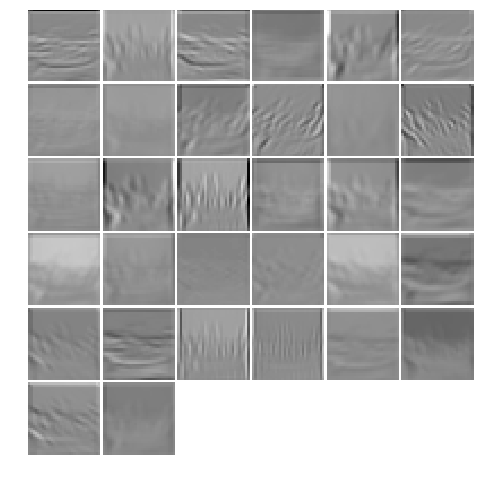

---------------------------------------------------------------------
NVDLA:


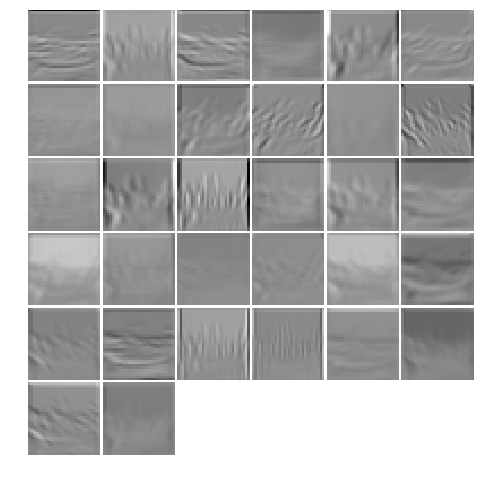

---------------------------------------------------------------------
Difference: 0.008977195248007774


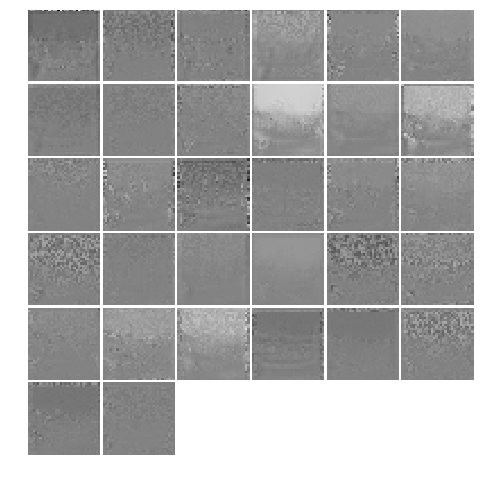

pool1 

32 , 16 , 16
Caffe:


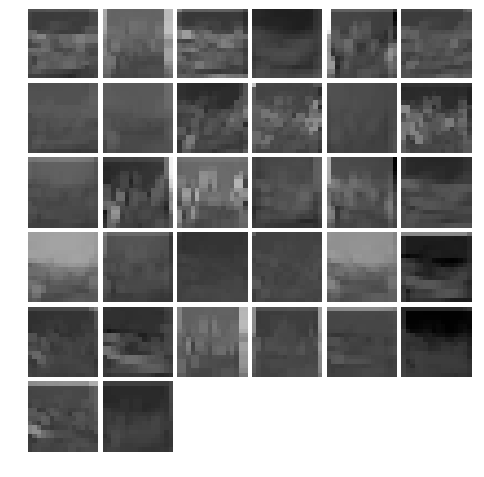

---------------------------------------------------------------------
NVDLA:


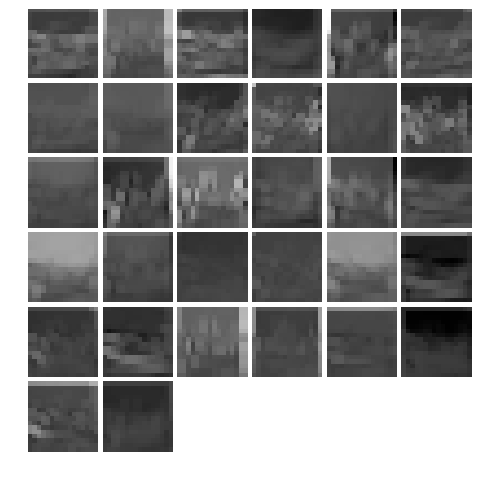

---------------------------------------------------------------------
Difference: 0.009085705503821373


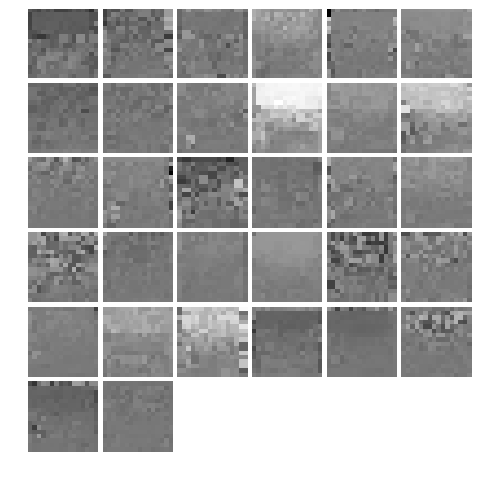

relu1 

32 , 16 , 16
Caffe:


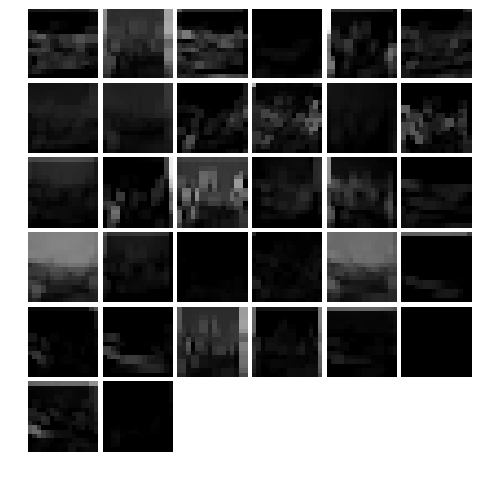

---------------------------------------------------------------------
NVDLA:


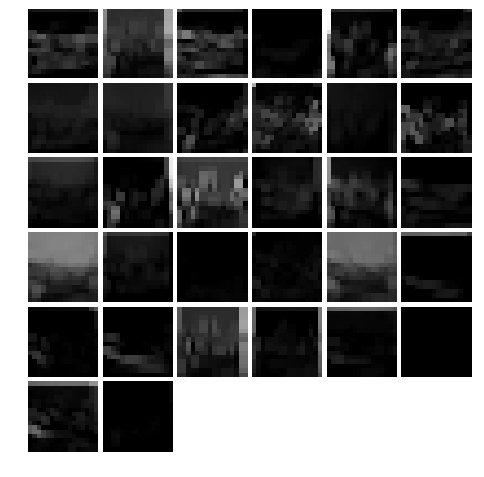

---------------------------------------------------------------------
Difference: 0.006677422672510147


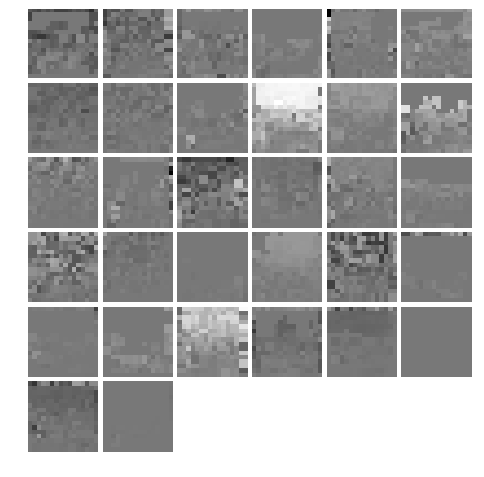

conv2 

32 , 16 , 16
Caffe:


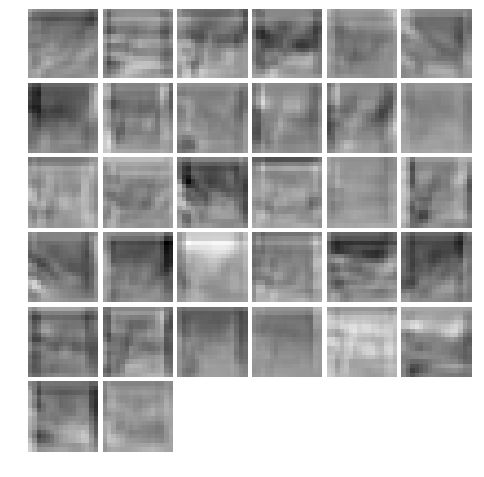

---------------------------------------------------------------------
NVDLA:


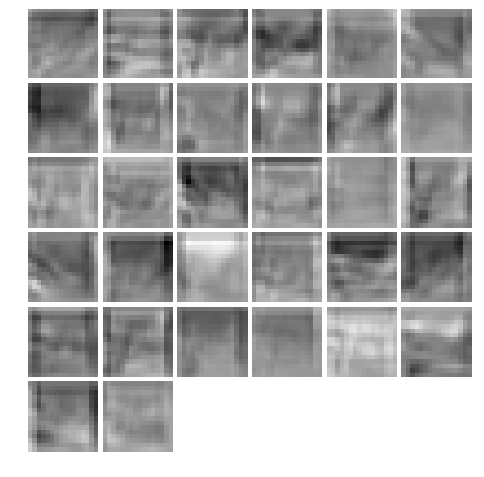

---------------------------------------------------------------------
Difference: 0.012167882174253464


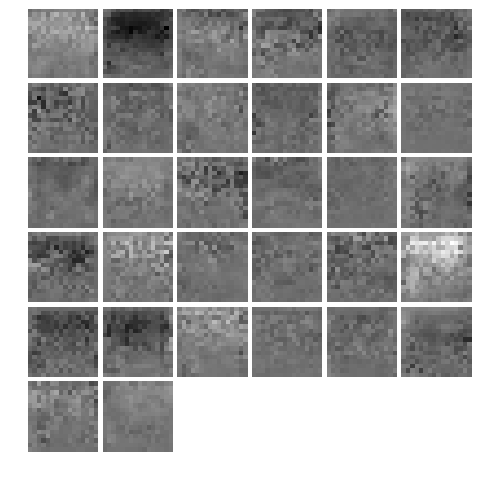

pool2 

32 , 16 , 16
Caffe:


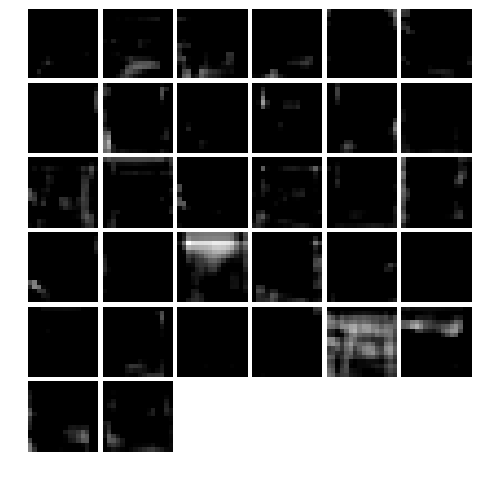

---------------------------------------------------------------------
NVDLA:


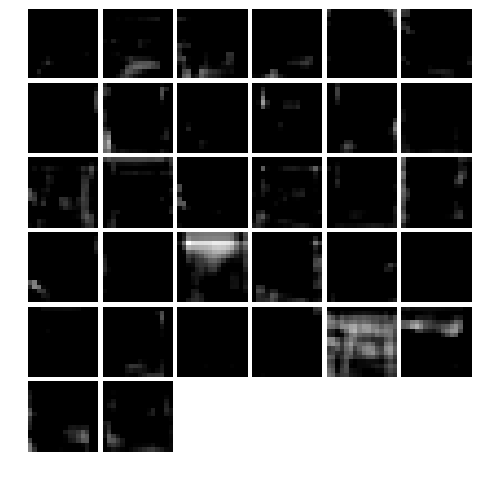

---------------------------------------------------------------------
Difference: 0.001361523987725377


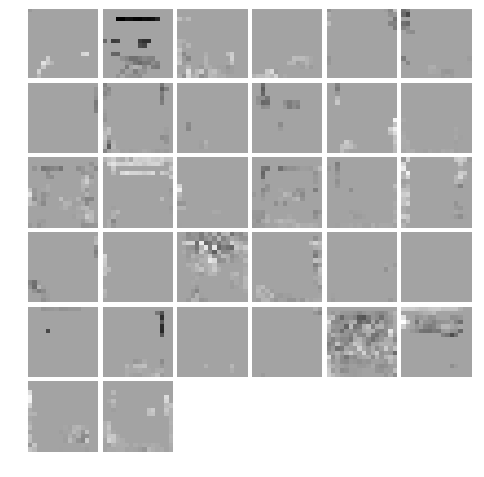

relu2 

32 , 8 , 8
Caffe:


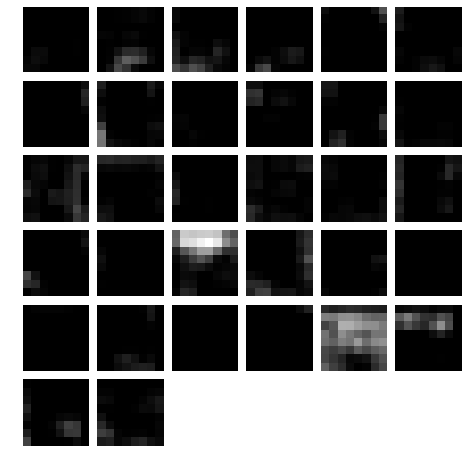

---------------------------------------------------------------------
NVDLA:


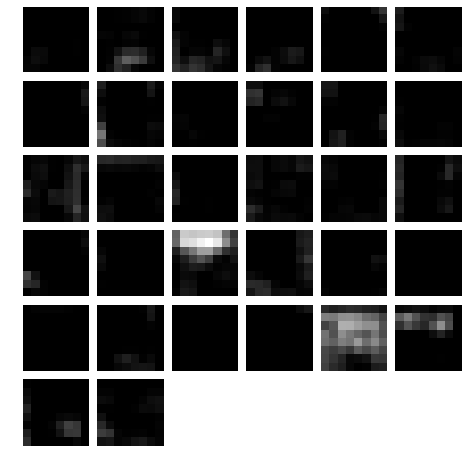

---------------------------------------------------------------------
Difference: 0.25080955028533936


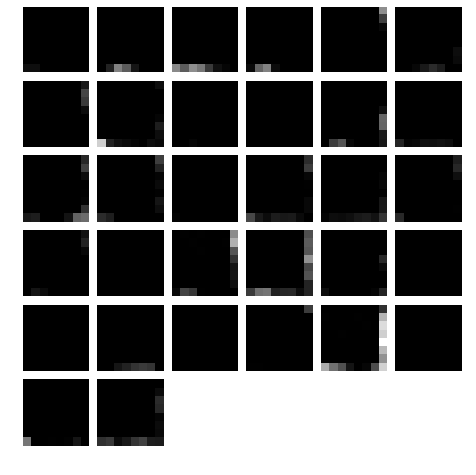

conv3 

64 , 8 , 8
Caffe:


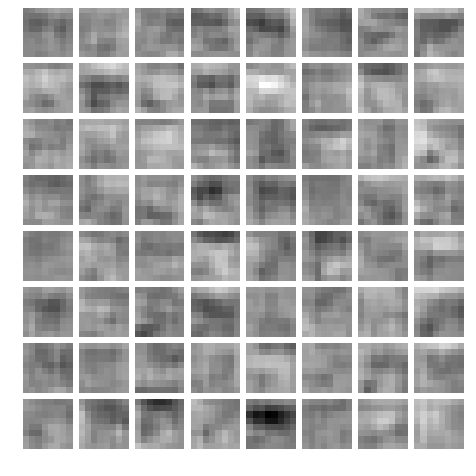

---------------------------------------------------------------------
NVDLA:


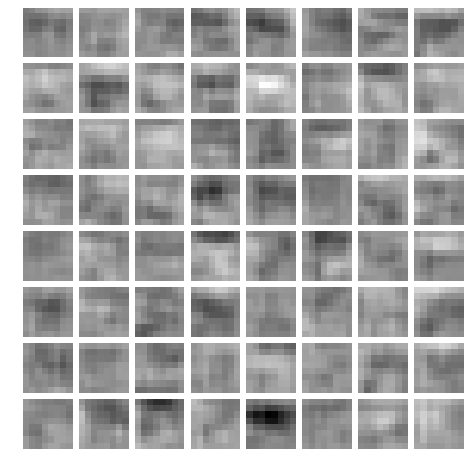

---------------------------------------------------------------------
Difference: 0.35034218430519104


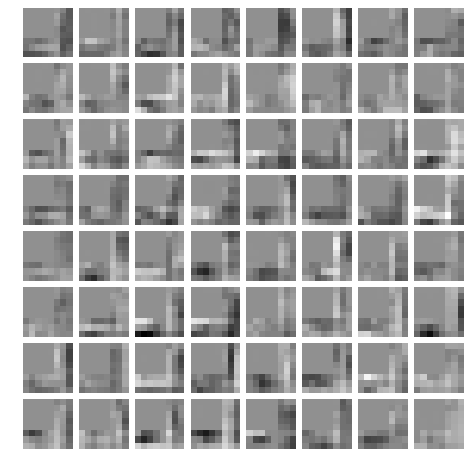

pool3 

64 , 8 , 8
Caffe:


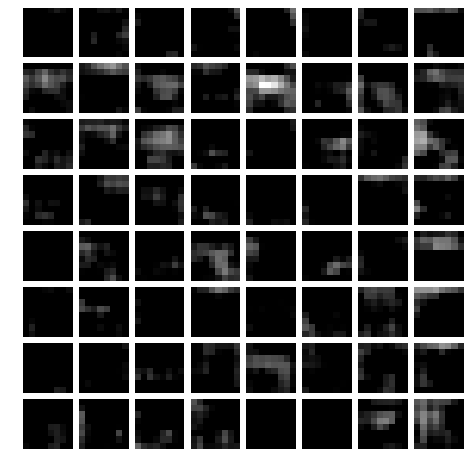

---------------------------------------------------------------------
NVDLA:


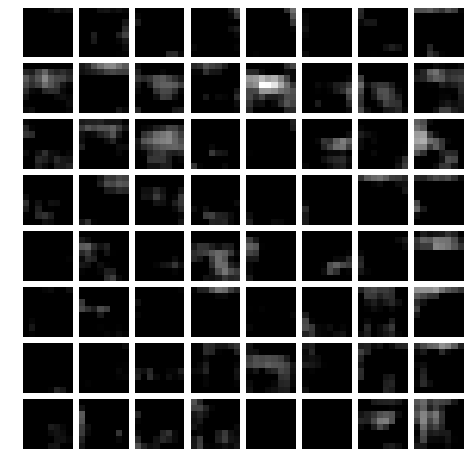

---------------------------------------------------------------------
Difference: 0.08529847860336304


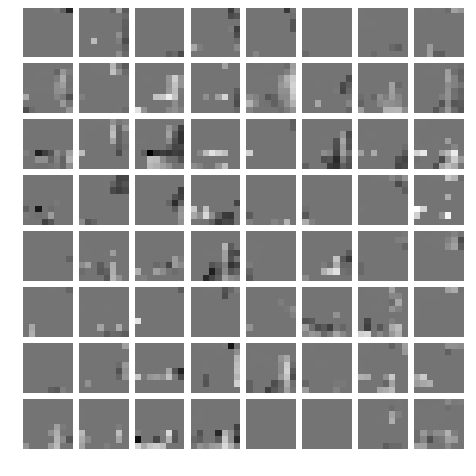

relu3 

64 , 4 , 4
Caffe:


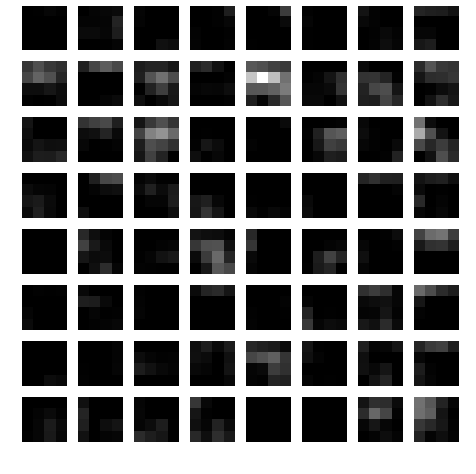

---------------------------------------------------------------------
NVDLA:


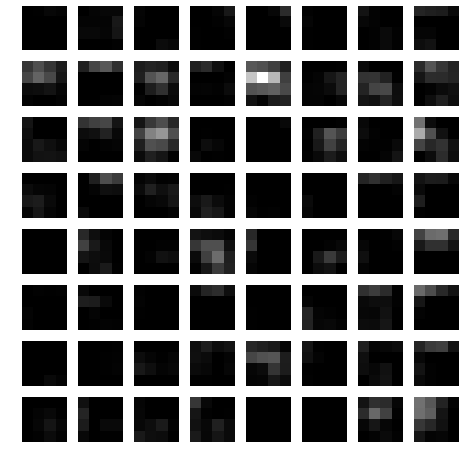

---------------------------------------------------------------------
Difference: 0.1265612095594406


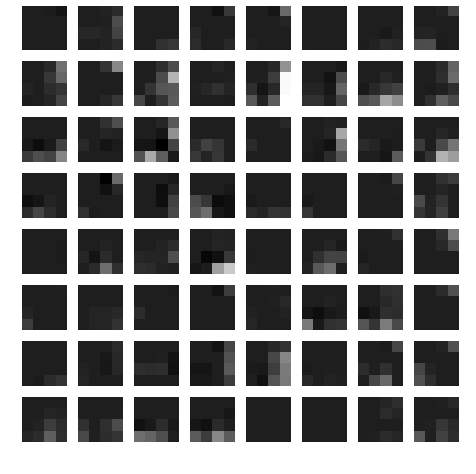

In [22]:
# np.set_printoptions(threshold=np.nan)
for result in result_list:
    if result['image_name'] == "18_ship":
        if result['layer'] != "prob":
            if result['layer'] != "ip1":
                if result['layer'] != "ip2":
                    print result['layer'],"\n"
                    print len(result['caffe']), ",", len(result['caffe'][0]), ",", len(result['caffe'][0][0])
                    caffe_tmp = result['caffe']
                    nvdla_tmp = result['nvdla'].reshape(len(caffe_tmp),len(caffe_tmp[0]),-1)

                    print "Caffe:"
                    show_data(caffe_tmp)
                    plt.show()
                    print "---------------------------------------------------------------------"
                    print "NVDLA:"
                    show_data(nvdla_tmp)
                    plt.show()
                    print "---------------------------------------------------------------------"
                    print "Difference:",result['diff']
                    show_data(caffe_tmp - nvdla_tmp)
                    plt.show()
                    print "====================================================================="


conv1 

32 , 32 , 32
Caffe:


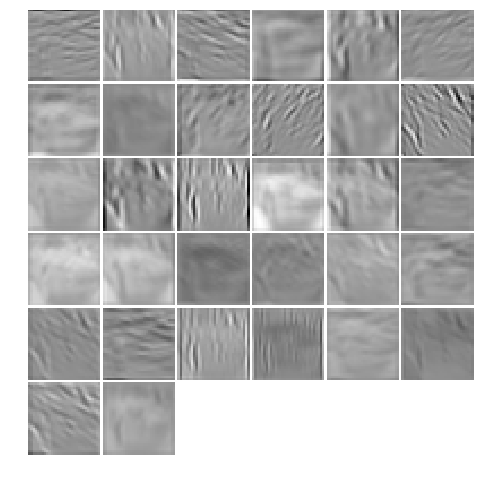

---------------------------------------------------------------------
NVDLA:


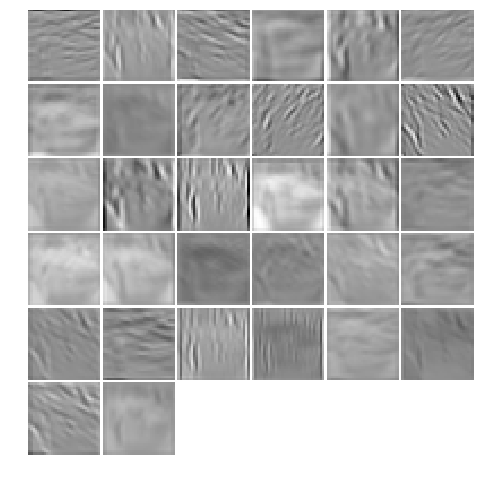

---------------------------------------------------------------------
Difference: 0.00704062357544899


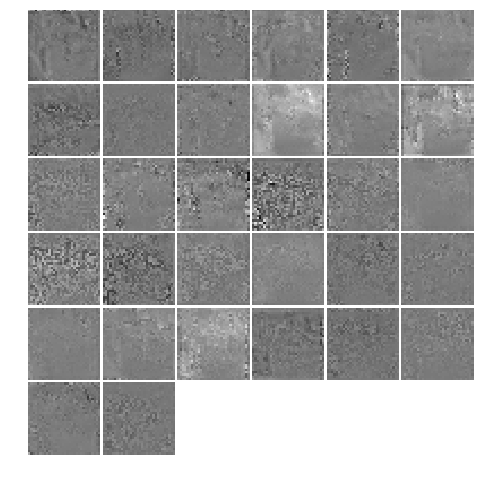

pool1 

32 , 16 , 16
Caffe:


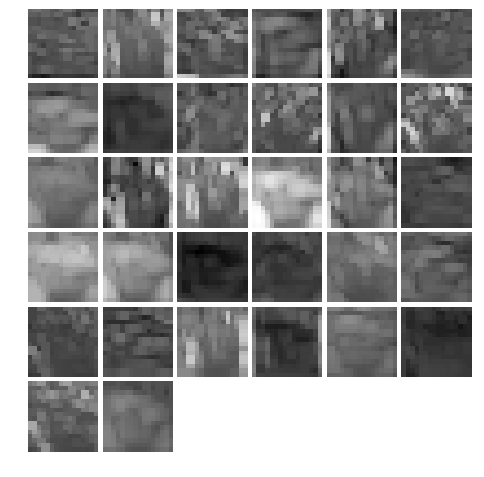

---------------------------------------------------------------------
NVDLA:


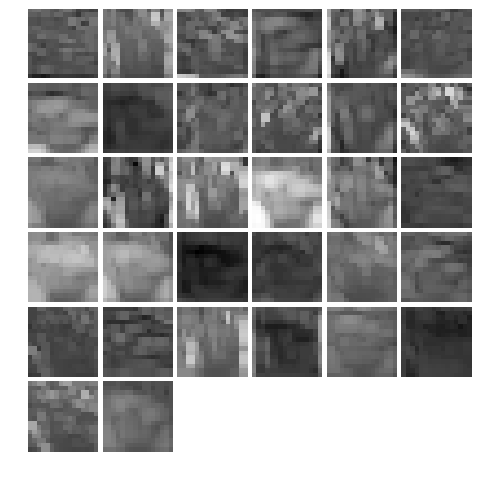

---------------------------------------------------------------------
Difference: 0.007697850465774536


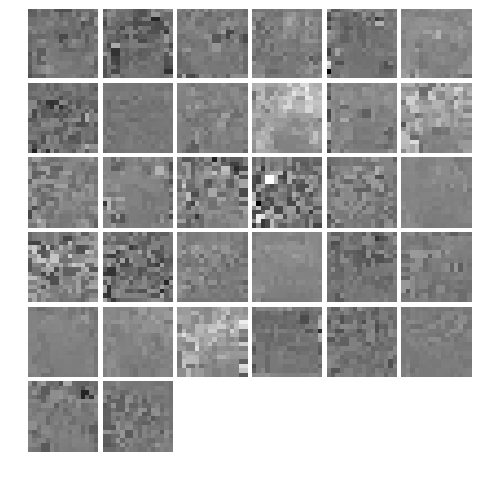

relu1 

32 , 16 , 16
Caffe:


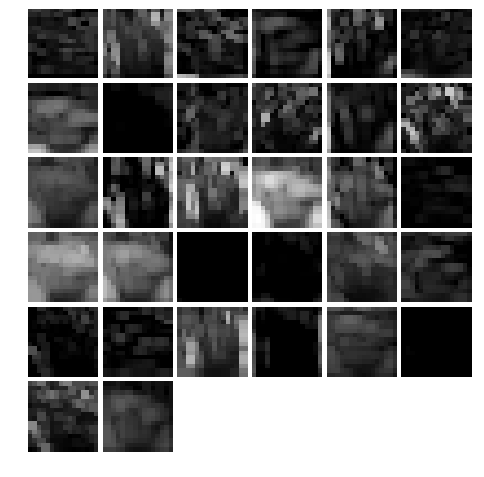

---------------------------------------------------------------------
NVDLA:


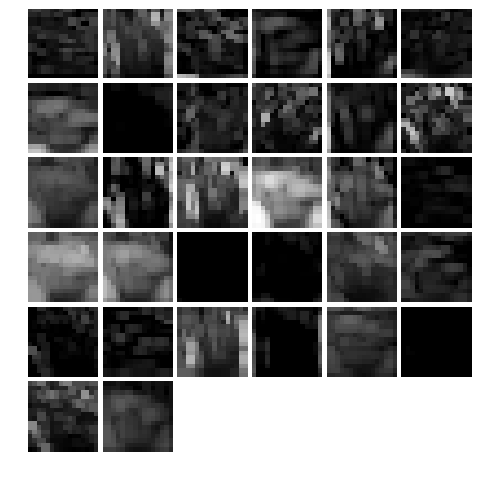

---------------------------------------------------------------------
Difference: 0.006823888048529625


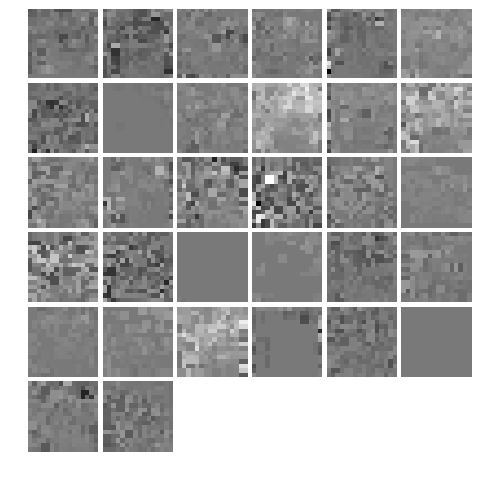

conv2 

32 , 16 , 16
Caffe:


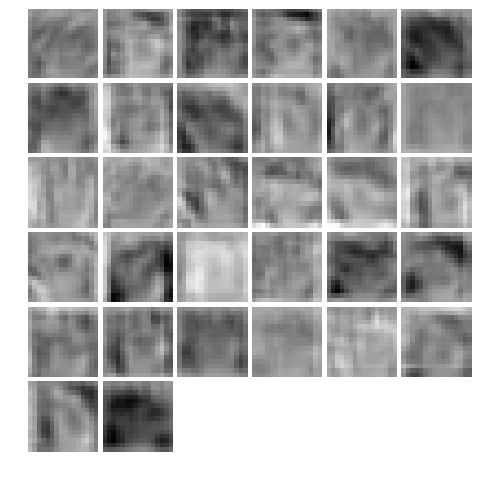

---------------------------------------------------------------------
NVDLA:


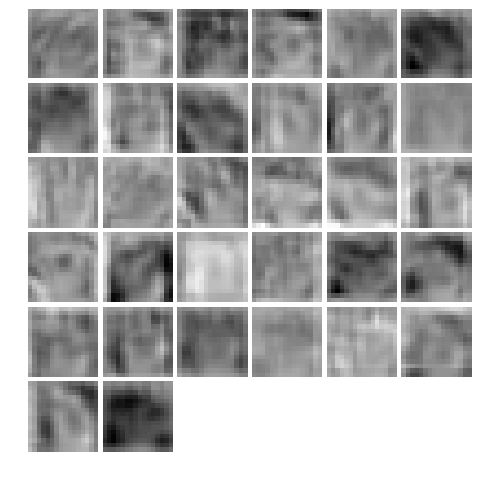

---------------------------------------------------------------------
Difference: 0.011879853904247284


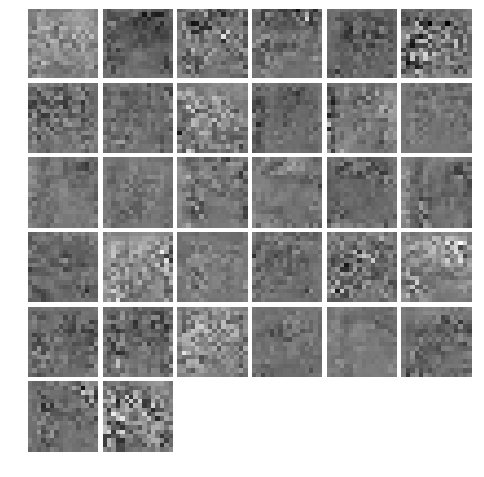

pool2 

32 , 16 , 16
Caffe:


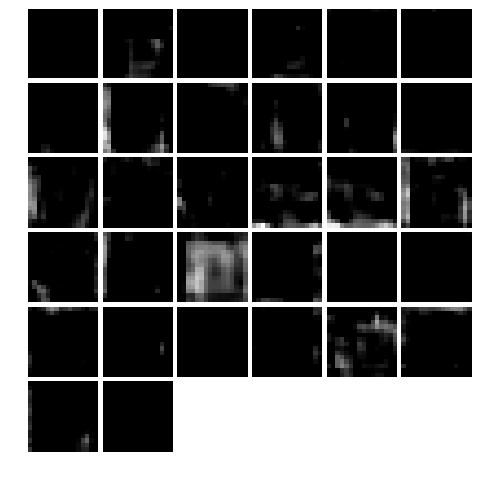

---------------------------------------------------------------------
NVDLA:


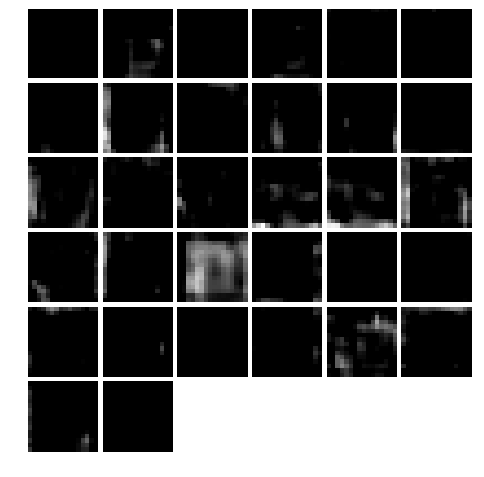

---------------------------------------------------------------------
Difference: 0.0010242927819490433


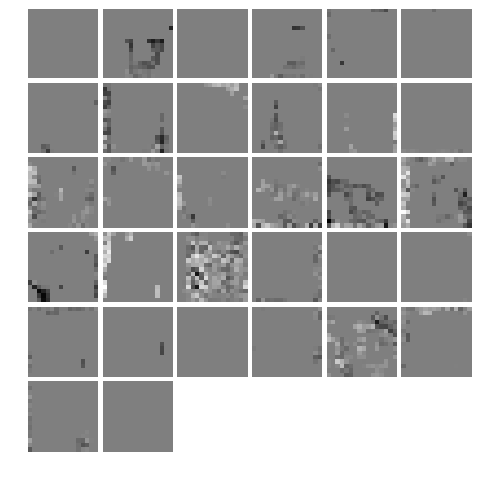

relu2 

32 , 8 , 8
Caffe:


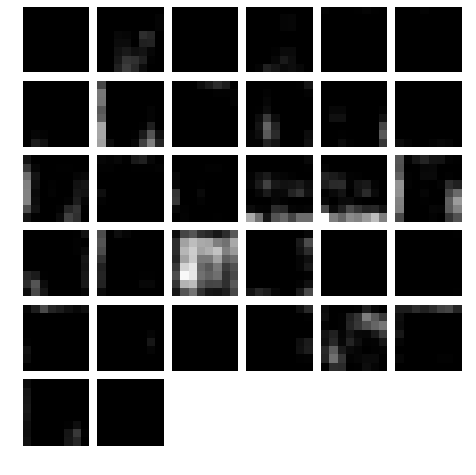

---------------------------------------------------------------------
NVDLA:


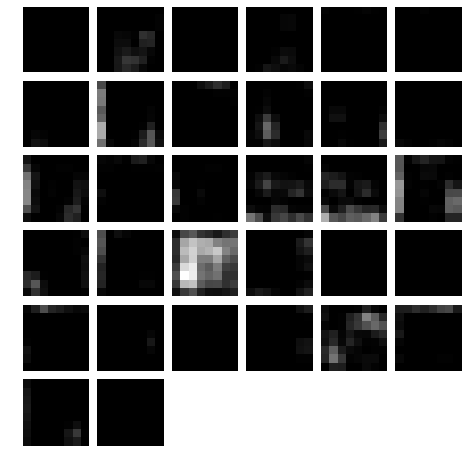

---------------------------------------------------------------------
Difference: 0.31791257858276367


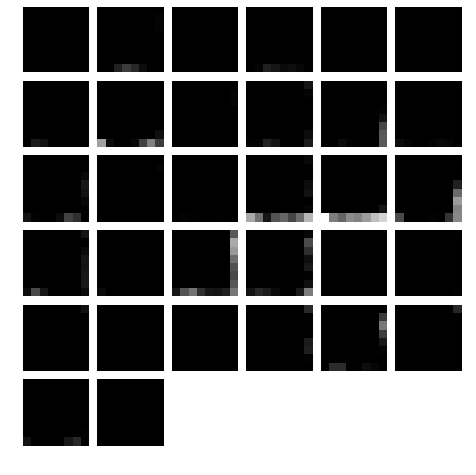

conv3 

64 , 8 , 8
Caffe:


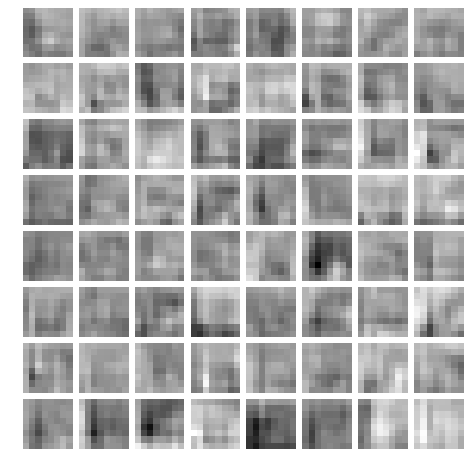

---------------------------------------------------------------------
NVDLA:


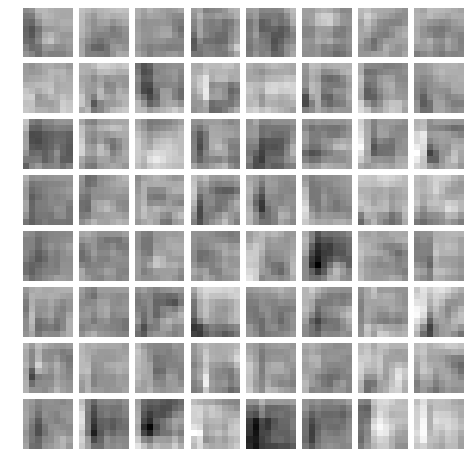

---------------------------------------------------------------------
Difference: 0.46015313267707825


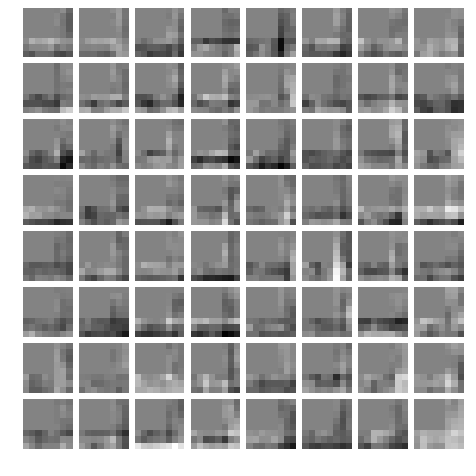

pool3 

64 , 8 , 8
Caffe:


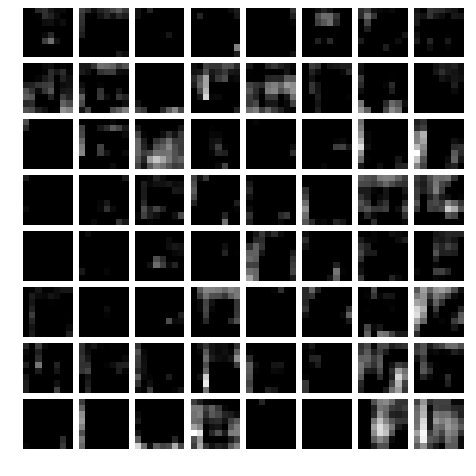

---------------------------------------------------------------------
NVDLA:


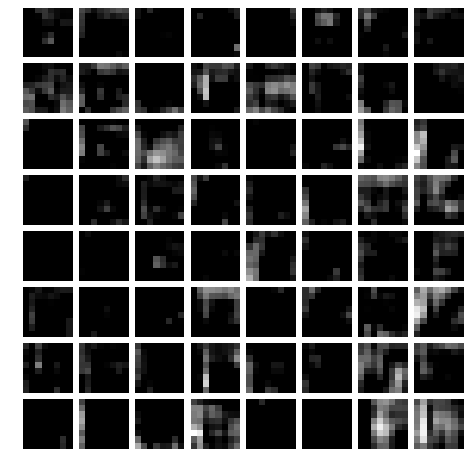

---------------------------------------------------------------------
Difference: 0.1129315048456192


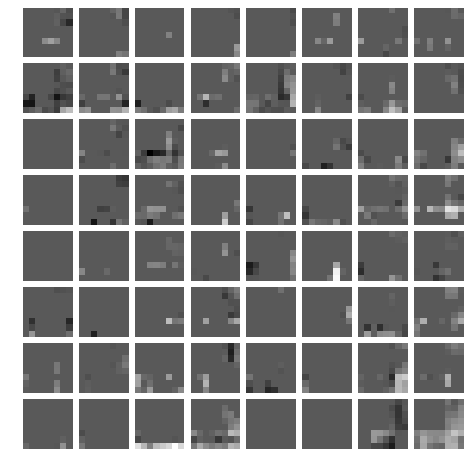

relu3 

64 , 4 , 4
Caffe:


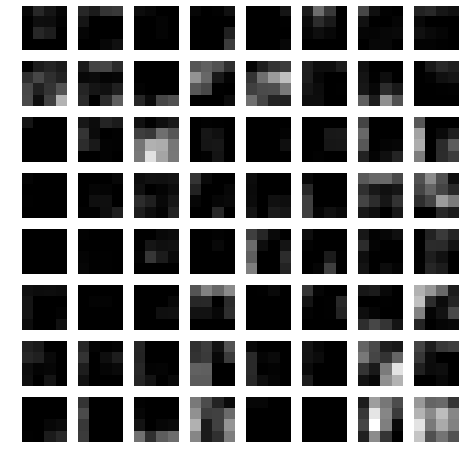

---------------------------------------------------------------------
NVDLA:


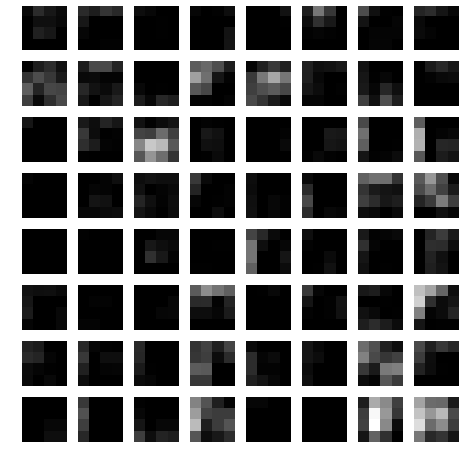

---------------------------------------------------------------------
Difference: 0.1764305830001831


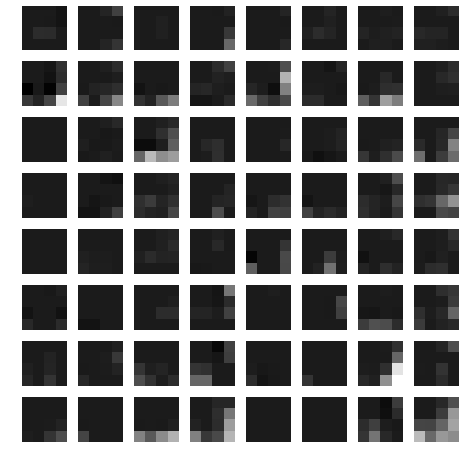

In [23]:
# np.set_printoptions(threshold=np.nan)
for result in result_list:
    if result['image_name'] == "5_automobile":
        if result['layer'] != "prob":
            if result['layer'] != "ip1":
                if result['layer'] != "ip2":
                    print result['layer'],"\n"
                    print len(result['caffe']), ",", len(result['caffe'][0]), ",", len(result['caffe'][0][0])
                    caffe_tmp = result['caffe']
                    nvdla_tmp = result['nvdla'].reshape(len(caffe_tmp),len(caffe_tmp[0]),-1)

                    print "Caffe:"
                    show_data(caffe_tmp)
                    plt.show()
                    print "---------------------------------------------------------------------"
                    print "NVDLA:"
                    show_data(nvdla_tmp)
                    plt.show()
                    print "---------------------------------------------------------------------"
                    print "Difference:",result['diff']
                    show_data(caffe_tmp - nvdla_tmp)
                    plt.show()
                    print "====================================================================="